# Module 3 - Exercise 0: Training Basics

## Learning Objectives
- Generate and visualize a synthetic classification dataset
- Split data into training, validation, and test sets
- Build a simple neural network for binary classification
- Select appropriate loss function and optimizer
- Implement a basic training loop
- Visualize decision boundaries
- Evaluate model performance on test data

## Environment Setup

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Section 1: Dataset Generation and Visualization

We'll start by generating a circles dataset - a classic non-linearly separable classification problem. This dataset consists of two concentric circles, where points from each circle belong to different classes.

In [15]:
# TODO: Generate a circles dataset with 1000 samples, noise=0.1, and factor=0.5

X, y = make_circles(n_samples=1000, noise=0.1, factor=0.5, random_state=42)

# Verify the shapes
print(f"Features shape: {X.shape if X is not None else 'Not generated'}")
print(f"Labels shape: {y.shape if y is not None else 'Not generated'}")
print(f"Unique labels: {np.unique(y) if y is not None else 'Not generated'}")

Features shape: (1000, 2)
Labels shape: (1000,)
Unique labels: [0 1]


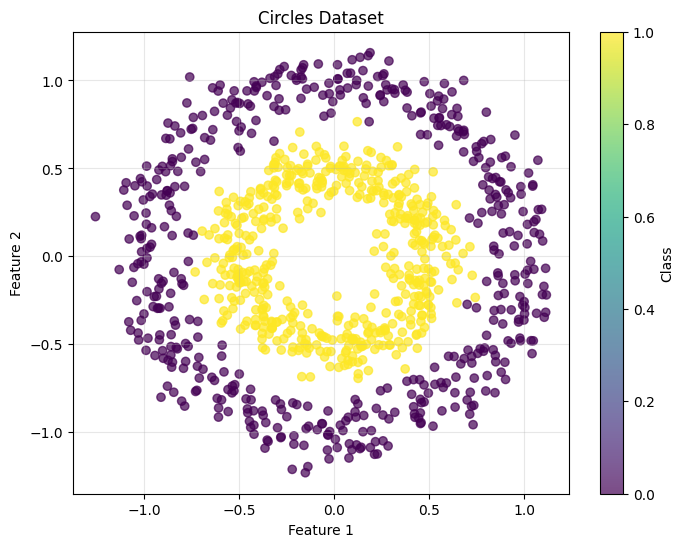

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Circles Dataset')
plt.colorbar(label='Class')
plt.grid(True, alpha=0.3)
plt.show()

## Section 2: Data Splitting

Proper data splitting is crucial for evaluating model performance. We need:
- **Training set**: For learning model parameters
- **Validation set**: For hyperparameter tuning and monitoring during training
- **Test set**: For final unbiased evaluation

**Question**: Why is it important to have separate validation and test sets? What problems could arise if we only used training and test sets?

In [32]:
# TODO: Split the data into train (60%), validation (20%), and test (20%) sets
# First split into train+val and test, then split train+val into train and val
n = len(X)
X_train, X_val, y_train, y_val, X_test, y_test = X[:int(n*0.6)], X[int(n*0.6):int(n*0.8)], y[:int(n*0.6)], y[int(n*0.6):int(n*0.8)], X[int(n*0.8):], y[int(n*0.8):]

# Verify the splits
print(f"Training set: {X_train.shape if X_train is not None else 'Not split'}")
print(f"Validation set: {X_val.shape if X_val is not None else 'Not split'}")
print(f"Test set: {X_test.shape if X_test is not None else 'Not split'}")

Training set: (600, 2)
Validation set: (200, 2)
Test set: (200, 2)


In [30]:
X[5]

array([-0.2601254 ,  0.55115763])

In [57]:
# TODO: Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, device="cuda")
y_train_tensor = torch.tensor(y_train, device="cuda")
X_val_tensor = torch.tensor(X_val, device="cuda")
y_val_tensor = torch.tensor(y_val, device="cuda")
X_test_tensor = torch.tensor(X_test, device="cuda")
y_test_tensor = torch.tensor(y_test, device="cuda")

print(f"Tensors created: {X_train_tensor is not None}")

Tensors created: True


## Section 3: Model Architecture

For this non-linearly separable problem, we need a neural network with at least one hidden layer. The network should:
- Accept 2D input (two features)
- Have hidden layers with non-linear activations
- Output a single value for binary classification

**Question**: Why do we need non-linear activation functions? What would happen if we only used linear layers?

In [84]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=16):
        super(BinaryClassifier, self).__init__()
        # TODO: Define the network architecture
        # Suggested: 2 -> 16 -> 8 -> 1
        # Use ReLU activations for hidden layers
        self.fc1 = nn.Linear(input_dim, hidden_dim, device="cuda")
        self.fc2 = nn.Linear(16, 8, device="cuda")
        self.fc3 = nn.Linear(8, 1, device="cuda")
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # TODO: Implement the forward pass
        # Apply layers and activations
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return self.sigmoid(x)

# TODO: Instantiate the model
model = BinaryClassifier()

# Display model architecture
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

BinaryClassifier(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)
Total parameters: 193


## Section 4: Loss Function and Optimizer

For binary classification, we need to choose:
- **Loss function**: Measures how wrong our predictions are
- **Optimizer**: Updates model parameters to minimize the loss

**Question**: Binary Cross-Entropy Loss is commonly used for binary classification. What is the mathematical formula for BCE loss? Why is it suitable for this task?

In [85]:
# TODO: Define the loss function nn.BCELoss (Binary Cross-Entropy)
criterion = nn.BCELoss()

# TODO: Define the optimizer (optim.Adam(TODO, lr=0.001) and apply it to the params of the model)
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Loss function: {type(criterion).__name__ if criterion is not None else 'Not defined'}")
print(f"Optimizer: {type(optimizer).__name__ if optimizer is not None else 'Not defined'}")

Loss function: BCELoss
Optimizer: Adam


## Section 5: Training Loop

The training loop is the core of the learning process. Each epoch consists of:
1. Forward pass: Compute predictions
2. Loss calculation: Measure error
3. Backward pass: Compute gradients
4. Parameter update: Adjust weights

We'll also track validation loss to monitor for overfitting.

In [98]:
# Training configuration
num_epochs = 200
train_losses = []
val_losses = []

# TODO: Implement the training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()

    # TODO: Forward pass on training data
    outputs = model.forward(X_train_tensor)

    # TODO: Calculate training loss
    train_loss = criterion(outputs, y_train_tensor.unsqueeze(1))

    # TODO: Backward pass and optimization
    # Remember to zero gradients, backward, and step
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        # TODO: Calculate validation loss
        val_outputs = model.forward(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor.unsqueeze(1))

    # Store losses
    if train_loss is not None and val_loss is not None:
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

    # Print progress every 20 epochs
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

Epoch [20/200], Train Loss: 0.0464, Val Loss: 0.0696
Epoch [40/200], Train Loss: 0.0445, Val Loss: 0.0679
Epoch [60/200], Train Loss: 0.0427, Val Loss: 0.0664
Epoch [80/200], Train Loss: 0.0411, Val Loss: 0.0651
Epoch [100/200], Train Loss: 0.0395, Val Loss: 0.0638
Epoch [120/200], Train Loss: 0.0381, Val Loss: 0.0626
Epoch [140/200], Train Loss: 0.0368, Val Loss: 0.0612
Epoch [160/200], Train Loss: 0.0355, Val Loss: 0.0601
Epoch [180/200], Train Loss: 0.0344, Val Loss: 0.0590
Epoch [200/200], Train Loss: 0.0333, Val Loss: 0.0580


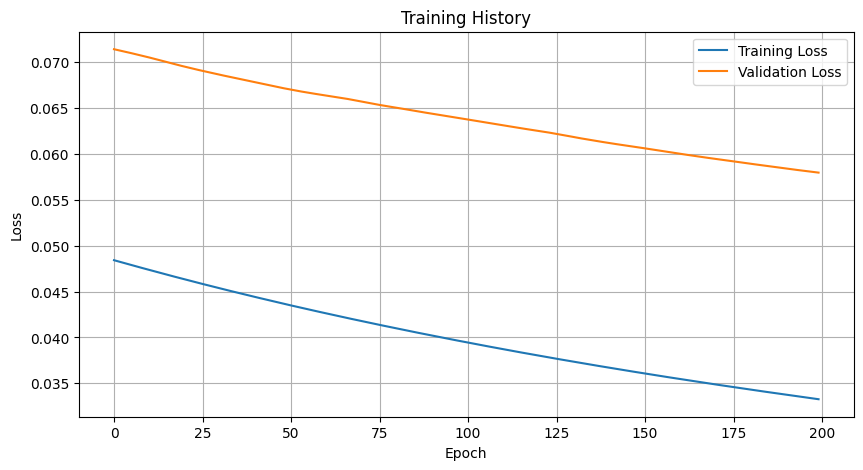

In [99]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

## Section 6: Decision Boundary Visualization

Visualizing the decision boundary helps us understand what the model has learned. For each point in a grid, we'll predict its class and color the region accordingly.

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


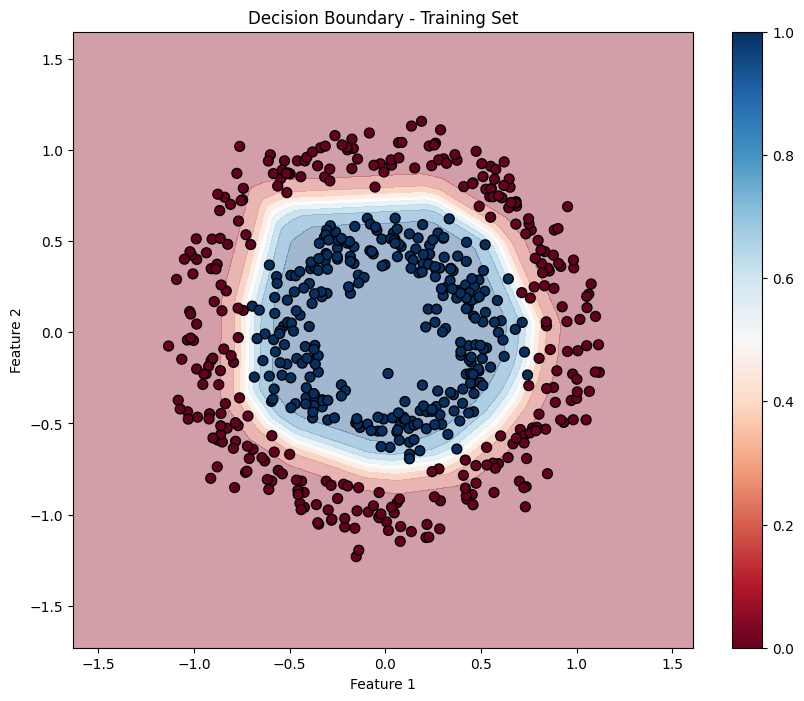

In [102]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_decision_boundary(model, X, y, title='Decision Boundary'):
    # Create a mesh grid
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Flatten xx and yy, create tensor, get predictions, reshape back
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32, device="cuda")

    model.eval()
    with torch.no_grad():
        predictions = model(grid_tensor)
        Z = torch.sigmoid(predictions).cpu().numpy()  # Get predictions, move to cpu and apply sigmoid
        Z = Z.reshape(xx.shape)  # Reshape back to grid shape

    # Plot the contour and data points
    plt.figure(figsize=(10, 8))
    if Z is not None:
        plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', edgecolor='black', s=50)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.colorbar()
    plt.show()

print(type(X_train), type(y_train))
plot_decision_boundary(model, X_train, y_train, 'Decision Boundary - Training Set')

## Section 7: Model Evaluation

Finally, we evaluate our model on the test set to get an unbiased estimate of its performance.

**Question**: Why is it important to evaluate on a test set that wasn't used during training or validation?

In [105]:
# TODO: Evaluate model on test set
model.eval()
with torch.no_grad():
    # TODO: Get predictions for test set using our model.(X_test)
    y_pred = model(X_test_tensor)

    # TODO: Calculate test loss nn.BCELoss(y_pred, y_test)
    test_loss = nn.BCELoss(y_pred, y_test_tensor.unsqueeze(1))

print(f"Test Loss: {test_loss.item() if test_loss is not None else 'Not calculated':.4f}")

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [ ]:
# TODO: Plot decision boundary for test data
if model is not None and X_test is not None:
    plot_decision_boundary(model, X_test, y_test, 'Decision Boundary - Test Set')